# Extract Sentences from Wikipedia
+ This notebook is used for collecting sentences that tell relationship between two entities from wikipedia using some dependency path pattern
+ **This notebook is fully valid under Owl3 machine (using the /scratch/data/wikipedia/full_text-2021-03-20 data)**

## Load necessary resource

In [2]:
import re
from bs4 import BeautifulSoup
import pandas as pd
import sys
import wikipedia
import os
from wikipedia2vec import Wikipedia2Vec
from collections import Counter
import bz2
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
from typing import List
from nltk.corpus import stopwords
self_define_stopwords = set(['-', ',', '.'])
sw = set(stopwords.words('english'))
import math
import json
import random
random.seed(0)
import torch

sys.path.append('..')

from tools.BasicUtils import my_read, my_write, my_read_pickle, my_write_pickle
from tools.TextProcessing import (
                my_sentence_tokenize,
                my_sentence_tokenize, filter_specific_keywords, nlp, 
                exact_match
                )

from extract_wiki import (
    wikipedia_entity_file, record_columns, 
    save_path, entity_occur_from_cooccur_file, entity_occur_from_selected_file, graph_file, single_sent_graph_file, 
    w2vec_dump_file, 
    w2vec_keyword2idx_file, 
    test_path, path_test_file, 
    path_pattern_count_file, 
    save_sub_folders, wiki_sub_folders, 
    wiki_files, save_sent_files, save_cooccur_files, save_selected_files, save_title_files, save_cooccur__files, 
    p, patterns, 
    note2line, line2note, process_file, filter_unrelated_from_df, cal_score_from_df, cal_freq_from_path, cal_freq_from_df, 
    feature_columns, feature_process, gen_pattern, gen_kw_from_wiki_ent, get_entity_page, load_pattern_freq, find_triangles, find_path_between_pair, 
    generate_sample, generate_second_level_sample, sample_to_neo4j
)

# Generate the save dir
if not os.path.exists(save_path):
    os.mkdir(save_path)

if not os.path.exists(test_path):
    os.mkdir(test_path)

for save_dir in save_sub_folders:
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

# Get all files under wikipedia/full_text-2021-03-20

print('wiki sub folder example:', wiki_sub_folders[0])
print('save sub folder example:', save_sub_folders[0])
print('wiki file example:', wiki_files[0])
print('save sentence file example:', save_sent_files[0])
print('save cooccur file example:', save_cooccur_files[0])
print('save selected sentence file example:', save_selected_files[0])

wiki sub folder example: ../data/wikipedia/full_text-2021-03-20/BE
save sub folder example: data/extract_wiki/wiki_sent_collect/BE
wiki file example: ../data/wikipedia/full_text-2021-03-20/BE/wiki_00
save sentence file example: data/extract_wiki/wiki_sent_collect/BE/wiki_00.dat
save cooccur file example: data/extract_wiki/wiki_sent_collect/BE/wiki_00_co.dat
save selected sentence file example: data/extract_wiki/wiki_sent_collect/BE/wiki_00_se.dat


In [ ]:
# [Load] wikipedia2vec
with bz2.open(w2vec_dump_file) as f_in:
    w2vec = Wikipedia2Vec.load(f_in)

In [ ]:
# [Test] wikipedia2vec

# Find similar words or entities
# ent1 = 'Python (programming language)'
# w2vec.most_similar_by_vector(w2vec.get_entity_vector(ent1), 20)

# Get similarity between two entities
# ent1 = 'Data mining'
# ent2 = 'Database system'
# cosine_similarity(w2vec.get_entity_vector(ent1).reshape(1, -1), w2vec.get_entity_vector(ent2).reshape(1, -1))[0, 0]

# Check the entity count and document count
ent1 = 'Hidden Markov model'
e = w2vec.get_entity(ent1)
print(e.count)
print(e.doc_count)

## [Preparation] Collect sentences, entities, entities co-occurrances, titles from wikipedia dump

### Roughly collect sentences, entity co-occurrances, titles

In [ ]:
# python extract_wiki.py collect_sent_and_cooccur (8 hours)

In [ ]:
# Collect wikipedia entities
wikipedia_entity = set()
for f in tqdm.tqdm(save_title_files):
    with open(f) as f_in:
        wikipedia_entity.update(f_in.read().split('\n'))
print(len(wikipedia_entity))
my_write(wikipedia_entity_file, list(wikipedia_entity))

In [ ]:
# Load wikipedia entities
with open(wikipedia_entity_file) as f_in:
    wikipedia_entity = set(f_in.read().split('\n'))

### Correct entity mapping in co-occurrance files

In [ ]:
w2vec
wikipedia_entity

# Generate lower-cased entity to original entity mapping
print('Generate lower-cased entity to original entity mapping')
wikipedia_entity_low2orig_map = {}
for ent in wikipedia_entity:
    ent_low = ent.lower()
    if ent_low not in wikipedia_entity_low2orig_map:
        wikipedia_entity_low2orig_map[ent_low] = []
    wikipedia_entity_low2orig_map[ent_low].append(ent)

# Correct mapping
print('Correct mapping')
for i in tqdm.tqdm(range(len(save_cooccur_files))):
    with open(save_cooccur_files[i]) as f_in:
        new_file_lines = []
        for line_idx, line in enumerate(f_in):
            line = line.strip()
            entities = line.split('\t')
            new_entities = []
            for ent in entities:
                if ent in wikipedia_entity:
                    new_entities.append(ent)
                else:
                    ent_low = ent.lower()
                    if ent_low in wikipedia_entity_low2orig_map:
                        candidates = wikipedia_entity_low2orig_map[ent_low]
                        if len(candidates) == 1:
                            new_entities.append(candidates[0])
                        else:
                            note = line2note(save_cooccur_files[i], line_idx, '_co.dat')
                            page_title = note2line(note, '_ti.dat').strip()
                            try:
                                page_ent_vec = w2vec.get_entity_vector(page_title)
                            except:
                                continue
                            most_similar_idx, most_similar_val = -1, -1
                            for candidate_idx, candidate_ent in enumerate(candidates):
                                try:
                                    candidate_vec = w2vec.get_entity_vector(candidate_ent)
                                except:
                                    continue
                                similar_val = cosine_similarity(page_ent_vec.reshape(1, -1), candidate_vec.reshape(1, -1))[0,0]
                                if similar_val > most_similar_val:
                                    most_similar_val = similar_val
                                    most_similar_idx = candidate_idx
                            if most_similar_idx >= 0:
                                new_entities.append(candidates[most_similar_idx])
            new_file_lines.append('\t'.join(new_entities))
        my_write(save_cooccur__files[i], new_file_lines)

In [ ]:
# [Test]
lines = get_entity_page('Machine learning')
sents = [note2line(note) for note in lines]
occurs = [note2line(note, '_co_.dat') for note in lines]
ori_occurs = [note2line(note, '_co.dat') for note in lines]
my_write('sent_check.txt', sents)
my_write('occur_check.txt', occurs)
my_write('ori_occur_check.txt', ori_occurs)
lines[0]

## [Not necessary] Mapping keyword mention to wikipedia2vec entities

In [ ]:
wikipedia_entity
w2vec

w2vec_keyword2idx = {}

for entity in tqdm.tqdm(wikipedia_entity):
    w2vec_entity = w2vec.get_entity(entity)
    if w2vec_entity is None:
        continue
    kw = gen_kw_from_wiki_ent(entity)
    if kw not in w2vec_keyword2idx:
        w2vec_keyword2idx[kw] = [w2vec_entity.index]
    else:
        if w2vec_entity.index not in w2vec_keyword2idx[kw]:
            w2vec_keyword2idx[kw].append(w2vec_entity.index)
w2vec_kws = filter_specific_keywords(list(w2vec_keyword2idx.keys()))
filter_keyword_from_w2vec = set(w2vec_kws)
w2vec_keyword2idx = {k:v for k, v in w2vec_keyword2idx.items() if k in filter_keyword_from_w2vec}
my_write_pickle(w2vec_keyword2idx_file, w2vec_keyword2idx)
len(w2vec_keyword2idx)

In [ ]:
# [Load] w2vec_keyword2idx
w2vec_keyword2idx = my_read_pickle(w2vec_keyword2idx_file)

In [ ]:
# [Test] w2vec_keyword2idx
kw = 'feature engineering'
kw_in_mention = kw in w2vec_keyword2idx
print(kw_in_mention)
if kw_in_mention:
    for idx in w2vec_keyword2idx[kw]:
        print(w2vec.dictionary.get_item_by_index(idx))

### [Test] Collect entity occurrance

In [ ]:
# Generate the entity occurrance dict from co-occurrance info [collect_ent_occur_from_cooccur]

## [Preparation] Collect dataset

### Collect pattern frequency counter

In [ ]:
# [Create] Collect sample data using general wikipedia2vec keywords and wiki sent files
wiki_path_test_df = pd.concat([pd.DataFrame(process_file(save_sent_files[file_idx], save_cooccur__files[file_idx], w2vec)) for file_idx in range(8)], ignore_index=True)
wiki_path_test_df.to_csv(path_test_file, sep='\t', columns=feature_columns, index=False)
print(len(wiki_path_test_df))

In [ ]:
# [Load] Load path test data (pd.DataFrame)
wiki_path_test_df = pd.read_csv(open(path_test_file), sep='\t')

In [ ]:
# [Create] Pattern frequency generation

sub_df = wiki_path_test_df[wiki_path_test_df['sim'] > 0.5]

sub_df = sub_df.assign(pick = sub_df.apply(lambda x: 1 if 'nsubj' in x['dep_path'] else 0, axis=1))
sub_df = sub_df[sub_df['pick'] > 0]

c = Counter(sub_df['pattern'].to_list())

my_write_pickle(path_pattern_count_file, c)

c.most_common(10)

In [ ]:
# [Load] cal_freq function
c, log_max_cnt = load_pattern_freq(path_pattern_count_file)

In [ ]:
# [Test] cal_freq function
cal_freq_from_path('i_nsubj prep pobj prep pobj', c, log_max_cnt)

### Simulate data collection process

In [ ]:
# [Test] Collect sample data using general wikipedia2vec keywords and wiki sent files
sub_df = filter_unrelated_from_df(wiki_path_test_df, 0.4)
sub_df = cal_freq_from_df(sub_df, c, log_max_cnt)
sub_df = cal_score_from_df(sub_df, 0.5, 0.25, 0.25)
sub_df = sub_df[sub_df['score'] > 0.5]
sub_df = sub_df.assign(sent = sub_df.apply(lambda x: note2line(x['sent']).strip(), axis=1))
sub_df.to_csv('full_phrase_check.tsv', columns = ['sent', 'kw1', 'kw1_recall', 'kw1_full_span', 'kw2', 'kw2_recall', 'kw2_full_span'], sep='\t', index=False)

### Collect data

In [ ]:
# [Create] collect dataset [collect_dataset]

### Generate entity occurrance from dataset

In [ ]:
# Get the entity occurance ['collect_ent_occur_from_selected']

### Check entity occurrance in dataset

In [ ]:
# [Load] entity occur dict which has occurance record for all entities in selected sentences
entity_occur_from_selected = my_read_pickle(entity_occur_from_selected_file)

# Demo check co-occur of two entities in selected sentences
def get_selected_record(entity_dict:dict, ent1:str, ent2:str):
    kw1_occur = entity_dict.get(ent1)
    kw2_occur = entity_dict.get(ent2)
    if not kw1_occur or not kw2_occur:
        return None
    co_occur = kw1_occur & kw2_occur
    data = []
    for occur in co_occur:
        record = note2line(occur, '_se.dat').strip().split('\t')
        sent = note2line(record[7]).strip()
        data_dict = {record_columns[i] : record[i] for i in range(len(record))}
        data_dict['sent'] = sent
        data.append(data_dict)
    df = pd.DataFrame(data = data)
    return df

In [ ]:
# [Test] entity occur dict

ent1 = 'Artificial intelligence'
# Check the existance of an entity
print(ent1 in entity_occur_from_selected)

# Check the sentences where an entity appear
# for note in entity_occur_from_selected[ent1]:
#     print(note2line(note2line(note, '_se.dat').split('\t')[7]).strip())

# Check the records of two entities
ent2 = 'Natural language processing'
df = get_selected_record(entity_occur_from_selected, ent1, ent2)
if df is not None:
    print(len(df))
    df.to_csv('sents.tsv', columns=['score'] + feature_columns + ['pattern', 'pattern_freq'], sep='\t', index=False)

## [Prepration] Sentence-edged Graph

### Generate graph

In [ ]:
# Generate the graph ['generate_graph']

### Generate single sentence graph

In [ ]:
# Generate single sentence graph ['generate_single_sent_graph']

### Check the basic properties of the graph

In [ ]:
# [Load] Graph
graph = my_read_pickle(graph_file)

print('num of nodes:', len(graph.nodes))
print('num of edges:', len(graph.edges))

In [ ]:
# [Test] graph
ent1 = 'Data mining'
# Check the neighbours of an entity
# list(graph.neighbors(ent1))

# Check the edges of two entities
graph.edges[ent1, 'Data fusion']

In [ ]:
# Show sentence from file
note2line('AC:32:2390')

In [ ]:
node2neig_cnt = {node : len(list(graph.neighbors(node))) for node in graph.nodes.keys()}

In [ ]:
neig_cnt = [v for v in node2neig_cnt.values() if v < 20]
plt.title('num of nodes vs num of neighbors each node')
plt.hist(neig_cnt)
plt.show()

In [ ]:
node2triangle_num = nx.triangles(graph)
print('num of triangles:', sum(node2triangle_num.values()) / 3)
plt.title('num of nodes vs num of triangles each node')
plt.hist([v for v in node2triangle_num.values() if v >= 1 and v < 10])
plt.show()

## Generate training data from single sentence graph

In [3]:
# [Load] Single sentence graph
graph = my_read_pickle(graph_file)
print('number of nodes:', graph.number_of_nodes())
print('number of edges:', graph.number_of_edges())

number of nodes: 1294537
number of edges: 3004240


### Generate data of level 1

In [15]:
# Test
ent1 = 'Machine learning'
ent2 = 'Artificial intelligence'
sample = generate_sample(graph, ent1, ent2)

In [16]:
sample

{'pair': ('Machine learning', 'Artificial intelligence'),
 'entity': ['Deep learning',
  'Computer science',
  'Software',
  'Google',
  'Intelligent agent',
  'Fuzzy logic',
  'Software engineering',
  'Computer vision',
  'Sepp Hochreiter',
  'Neural network software',
  'Computer program',
  'Library (computing)',
  'Artificial neural network',
  'Neural Designer',
  'Inductive logic programming',
  'Genetic algorithm',
  'Artificial intelligence',
  'Assistive technology',
  'DeepMind',
  'Natural language',
  'Algorithm',
  'Natural language processing',
  'Statistical relational learning',
  'IBM',
  'Machine learning',
  'Markov random field',
  'Logic programming'],
 'target': 'as a scientific endeavor , machine learning grew out of the quest for artificial intelligence .',
 'source': ['in march 2018 , google announced tensorflow.js version 1.0 for machine learning in javascript .',
  'in february 2017 , ibm announced the first machine learning hub in silicon valley to share ex

In [10]:
def sample_to_neo4j(sample:dict):
    cmd = ['MATCH (n) DETACH DELETE (n);']
    for ent in sample['pair']:
        cmd.append('CREATE (:ENT:TARGET {ent:"%s"});' % ent)
    for ent in sample['entity']:
        if ent not in sample['pair']:
            cmd.append('CREATE (:ENT:INTERMEDIA {ent:"%s"});' % ent)
    for path in sample['triple']:
        for tri in path:
            ent1 = sample['entity'][tri['e1']]
            ent2 = sample['entity'][tri['e2']]
            sent = sample['source'][tri['sent']]
            score = tri['score']
            cmd.append('MATCH (ent1:ENT {ent:"%s"}), (ent2:ENT {ent:"%s"}) CREATE (ent1)-[:Sent {sent:"%s", pair:"%s <-> %s", score:%.3f}]->(ent2);' % (ent1, ent2, sent, ent1, ent2, score))
    cmd.append('MATCH (ent1:ENT {ent:"%s"}), (ent2:ENT {ent:"%s"}) CREATE (ent1)-[:OUT {sent:"%s", pair:"%s <-> %s"}]->(ent2);' % (*sample['pair'], sample['target'], *sample['pair']))
    print('\n'.join(cmd))

In [17]:
sample_to_neo4j(sample)

MATCH (n) DETACH DELETE (n);
CREATE (:ENT:TARGET {ent:"Machine learning"});
CREATE (:ENT:TARGET {ent:"Artificial intelligence"});
CREATE (:ENT:INTERMEDIA {ent:"Deep learning"});
CREATE (:ENT:INTERMEDIA {ent:"Computer science"});
CREATE (:ENT:INTERMEDIA {ent:"Software"});
CREATE (:ENT:INTERMEDIA {ent:"Google"});
CREATE (:ENT:INTERMEDIA {ent:"Intelligent agent"});
CREATE (:ENT:INTERMEDIA {ent:"Fuzzy logic"});
CREATE (:ENT:INTERMEDIA {ent:"Software engineering"});
CREATE (:ENT:INTERMEDIA {ent:"Computer vision"});
CREATE (:ENT:INTERMEDIA {ent:"Sepp Hochreiter"});
CREATE (:ENT:INTERMEDIA {ent:"Neural network software"});
CREATE (:ENT:INTERMEDIA {ent:"Computer program"});
CREATE (:ENT:INTERMEDIA {ent:"Library (computing)"});
CREATE (:ENT:INTERMEDIA {ent:"Artificial neural network"});
CREATE (:ENT:INTERMEDIA {ent:"Neural Designer"});
CREATE (:ENT:INTERMEDIA {ent:"Inductive logic programming"});
CREATE (:ENT:INTERMEDIA {ent:"Genetic algorithm"});
CREATE (:ENT:INTERMEDIA {ent:"Assistive technol

In [ ]:
# Generate training data of level 1 [collect_one_hop_sample_from_single_sent_graph] (5 min)

In [3]:
with open('dataset_level_1.json') as f_in:
    a = json.load(f_in)
items = [item for item in a if len(item['source']) > 1]
len(items)

107684

In [4]:
random.shuffle(items)
train_ratio = 0.85
valid_ratio = 0.05
training_data = items[:int(len(items)*train_ratio)]
valid_data = items[int(len(items)*train_ratio):int(len(items)*(train_ratio+valid_ratio))]
test_data = items[int(len(items)*(train_ratio+valid_ratio)):]
with open('train.json', 'w') as f_out:
    json.dump(training_data, f_out)
with open('dev.json', 'w') as f_out:
    json.dump(valid_data, f_out)
with open('test.json', 'w') as f_out:
    json.dump(test_data, f_out)

In [8]:
training_data[0]['source']

['many christian church holding to a doctrine of the real presence of christ in the eucharist ( for example , catholic , eastern orthodox , lutheran , moravian , anglican , methodist , oriental orthodox , reformed , and irvingian ) reserve to ordained clergy the function of consecrating the eucharist , but not necessarily that of distributing the element to communicant .',
 'in the final part of the discourse ( ) jesus prays for his follower and the coming christian church .',
 'in christian theology the name of god has always had much deeper meaning and significance than being just a label or designator .',
 'in the middle age , satan played a minimal role in christian theology and was used as a comic relief figure in mystery play .',
 'in christian theology , the real presence of christ in the eucharist is the doctrine that jesus is present in the eucharist , not merely symbolically or metaphorically .',
 'many christian view the new jerusalem as a current reality , that the new jeru

In [13]:
sent_len_count = []
for data in training_data:
    sents = data['source']
    sent_len_count.extend([len(sent.split()) for sent in sents])

In [9]:
import matplotlib.pyplot as plt

In [11]:
x = np.array(sent_len_count)

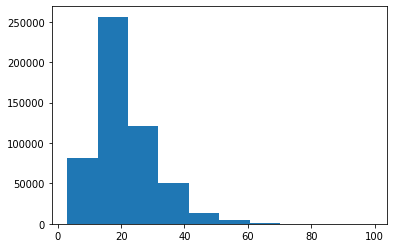

In [12]:
plt.hist(x[x<100])
plt.show()

In [7]:
len(sent_len_count)

529554

In [ ]:
sample_to_neo4j(items[5])

### Generate data of level 2 from level 1

In [ ]:
with open('temp.json') as f_in:
    sample = json.load(f_in)

In [ ]:
sample

In [ ]:
second_level_sample = generate_second_level_sample(sample)

In [ ]:
second_level_sample

In [ ]:
from graph4nlp.pytorch.data import GraphData

In [ ]:
dep_labels = list(nlp.get_pipe("parser").labels)
dep_labels.extend(['i_'+dep for dep in dep_labels])

In [ ]:
g = GraphData()
is_rel = []
is_entity = []

g.add_nodes(1)
is_rel.append(0)
is_entity.append(0)

for src in second_level_sample['sources']:
    pair = src['pair']
    sent_tokens = src['sent']
    
    label_list = []
    label_list.extend(sent_tokens)
    token_num = len(sent_tokens)
    start_node = g.get_node_num()
    g.add_nodes(token_num)
    is_rel.extend([0]*token_num)
    is_entity.extend([0]*token_num)
    is_entity[pair[0]+start_node] = 1
    is_entity[pair[1]+start_node] = 1
    
    label_list.extend(['ROOT', 'ROOT', 'i_ROOT', 'i_ROOT'])
    rel_start_node = start_node + token_num
    g.add_nodes(4)
    is_rel.extend([1]*4)
    is_entity.extend([0]*4)
    g.add_edges([0, 0], [rel_start_node, rel_start_node+1])
    g.add_edges([rel_start_node, rel_start_node+1], [pair[0]+start_node, pair[1]+start_node])
    g.add_edges([pair[0]+start_node, pair[1]+start_node], [rel_start_node+2, rel_start_node+3])
    g.add_edges([rel_start_node+2, rel_start_node+3], [0, 0])
    
    rel_start_node += 4
    triples = src['graph']
    rel_num = len(triples)
    is_rel.extend([1]*rel_num)
    is_entity.extend([0]*rel_num)
    g.add_nodes(rel_num)
    for rel_idx, (tok_1, tok_2, rel) in enumerate(triples):
        g.add_edges([tok_1+start_node, rel_idx+rel_start_node], [rel_idx+rel_start_node, tok_2+start_node])
        label_list.append(rel)
    for i, label in enumerate(label_list):
        g.node_attributes[i+start_node]['label'] = label
g.node_features['is_rel'] = torch.BoolTensor(is_rel)
g.node_features['is_entity'] = torch.BoolTensor(is_entity)

In [ ]:
g.get_edge_num()

In [ ]:
def find_triangle_with_node(graph:nx.Graph, first_node:str, second_node:str='', third_node:str=''):
    triangles = list(find_triangles(graph, first_node))
    triangles.sort(key=lambda x: x[1])
    triangle_with_sents = []
    n_seen = set()
    for n1, n2, n3 in triangles:
        if second_node and n2 != second_node and n3 != second_node:
            continue
        if third_node and n2 != third_node and n3 != third_node:
            continue
        if n2 not in n_seen:
            n_seen.add(n2)
            triangle_with_sents.append((n1, note2line(graph.get_edge_data(n1, n2)['note']).strip(), n2, graph.get_edge_data(n1, n2)['score']))
        if n3 not in n_seen:
            n_seen.add(n3)
            triangle_with_sents.append((n1, note2line(graph.get_edge_data(n1, n3)['note']).strip(), n3, graph.get_edge_data(n1, n3)['score']))
        triangle_with_sents.append((n2, note2line(graph.get_edge_data(n3, n2)['note']).strip(), n3, graph.get_edge_data(n3, n2)['score']))
    return triangle_with_sents


def isf(w:str, D:int, counters:List[Counter]):
    return math.log(D * 1.0 / sum([1 if w in sent else 0 for sent in counters]))


def do_pagerank(sents:List[str]):
    # Remove stop words
    clean_sents = [[token for token in sent.split() if token not in sw and token not in self_define_stopwords] for sent in sents]

    # Generate word counters
    counters = [Counter(sent) for sent in clean_sents]

    # Build similarity matrix
    D = len(clean_sents)
    sim_matrix = np.zeros((D, D))
    part_list = [math.sqrt(sum([(sent[w] * isf(w, D, counters)) ** 2 for w in sent])) for sent in counters]
    # return part_list
    for i in range(D - 1):
        for j in range(i + 1, D):
            sent_1 = counters[i]
            sent_2 = counters[j]
            share_word_set = sent_1 & sent_2
            numerator = sum([(sent_1[w] * sent_2[w] * (isf(w, D, counters) ** 2)) for w in share_word_set])
            denominator = part_list[i] * part_list[j]
            sim_matrix[i, j] = numerator / denominator
    sim_matrix = sim_matrix + sim_matrix.T
    g = nx.from_numpy_array(sim_matrix)
    score = nx.pagerank(g)
    temp = sorted(score.items(), key=lambda x: x[1], reverse=True)
    idx = [item[0] for item in temp]
    return [sents[i] for i in idx], [score[i] for i in idx]

In [ ]:
test_triangles = find_triangle_with_node(single_sent_graph, 'Machine learning', 'Artificial neural network', 'Deep learning')
test_triangles

In [ ]:
sent_list = [triangle[1] for triangle in test_triangles]
sents, score = do_pagerank(sent_list)
list(zip(score, sents))

## [Test] Check the score function

### Collect test data

In [ ]:
# [collect_score_function_eval_dataset]

### Test score function with human evaluation

In [ ]:
c, log_max_cnt = load_pattern_freq(path_pattern_count_file)

pattern_freq_w = 0.55
kw_recall_w = 0.25
coverage_w = 0.2

def get_score(sent:str, ent1:str, ent2:str):
    kw1 = gen_kw_from_wiki_ent(ent1)
    kw2 = gen_kw_from_wiki_ent(ent2)
    data = feature_process(nlp(sent), [{'kw1' : kw1, 'kw2' : kw2}])
    if not data:
        return -1
    data = data[0]
    pattern_freq = cal_freq_from_path(gen_pattern(data['dep_path']), c, log_max_cnt)
    return ((pattern_freq)**pattern_freq_w) * (((data['kw1_recall'] + data['kw2_recall']) / 2)**kw_recall_w) * (((data['dep_coverage'] + data['surface_coverage']) / 2)**coverage_w)

test_data = pd.read_csv('test.tsv', sep='\t')
score_function_result = test_data.copy()
score_function_result['score'] = score_function_result.apply(lambda x: get_score(x['sentence'], x['entity 1'], x['entity 2']), axis=1)
score_function_result.to_csv('score_function_result.tsv', sep='\t', index=False)

In [ ]:
with open('score_function_result.tsv') as f_in:
    lines = f_in.readlines()
    sf_score = [float(lines[i].strip().split('\t')[-1]) for i in range(1, len(lines))]
    sf_score = np.array(sf_score)

with open('user_label.tsv') as f_in:
    lines = f_in.readlines()
    user_score = [float(lines[i].strip().split('\t')[-1]) / 5 for i in range(1, len(lines))]
    user_score = np.array(user_score)
    
with open('user_label.tsv') as f_in:
    lines = f_in.readlines()
    data = []
    for i in range(1, len(lines)):
        ent1, ent2, sent, user_score_ = lines[i].strip().split('\t')
        data.append({'entity 1' : ent1, 'entity 2' : ent2, 'sentence' : sent, 'user label' : float(user_score_)/5})
        
sf_score = sf_score[user_score > 0]
user_score = user_score[user_score > 0]

In [ ]:
np.corrcoef(sf_score, user_score)

In [ ]:
# score range within [1,2,3,4,5]
l2 = np.mean(np.abs(sf_score*5 - user_score*5))
l2

In [ ]:
np.mean(user_score*5)

In [ ]:
np.mean(user_score[sf_score>0.7])

In [ ]:
np.mean(user_score[sf_score<=0.6])

In [ ]:
np.mean(sf_score*5)

In [ ]:
dist = np.abs(sf_score - user_score)
diff = []
for i in range(len(dist)):
    if dist[i] > 0.3:
        diff.append(data[i].copy())
        diff[-1]['score function label'] = sf_score[i]
diff = pd.DataFrame(diff)

In [ ]:
len(diff)

In [ ]:
diff.to_csv('diff.tsv', sep='\t', index=False)

## Generate Super Sub-graph

### Collect all sentences between two entities within one hop

In [ ]:
# [Load] Single sentence graph
single_sent_graph = my_read_pickle(single_sent_graph_file)
edges = [edge for edge in tqdm.tqdm(single_sent_graph.edges) if single_sent_graph.get_edge_data(*edge)['score'] > 0.65]
filtered_graph = single_sent_graph.edge_subgraph(edges)
print('number of nodes:', filtered_graph.number_of_nodes())
print('number of edges:', filtered_graph.number_of_edges())

In [ ]:
paths = find_path_between_pair(single_sent_graph, 'Artificial intelligence', 'Natural language processing', 1)

In [ ]:
def build_subgraph(paths:list, single_sent_graph:nx.Graph):
    pairs = set()
    triples = []
    for path in paths:
        if len(path) <= 2:
            continue
        for i in range(len(path)-1):
            new_pair = frozenset((path[i], path[i+1]))
            if new_pair not in pairs:
                pairs.add(new_pair)
                triples.append(list(new_pair) + [note2line(single_sent_graph.get_edge_data(path[i], path[i+1])['note']).strip()])
    return triples

In [ ]:
subgraph = build_subgraph(paths, single_sent_graph)

### Generate a graph for one sentence

## Demo

In [ ]:
# Analyze sentence
doc = nlp('sephardi were exempt from the ban , but it appears that few applied for a letter of free passage .')

# Check noun phrases in the sentences
print(list(doc.noun_chunks))

In [ ]:
len(doc)

In [ ]:
doc = nlp('ada is a structured , statically typed , imperative , and object-oriented high-level programming language , extended from pascal and other language .')
pairs = [{'kw1' : 'ada', 'kw2' : 'programming language'}]
feature_process(doc, pairs)

## [Not necessary] Online operations

In [ ]:
def collect_sents_from_wiki_page(page:wikipedia.WikipediaPage):
    remove_list = ['See also', 'References', 'Further reading', 'Sources', 'External links']
    dic = {sec : page.section(sec) for sec in page.sections}
    dic['summary'] = page.summary
    sents = []
    section_list = list(dic.keys())
    while len(section_list) > 0:
        section = section_list.pop()
        if section in remove_list:
            continue
        section_text = dic[section]
        if not section_text:
            continue
        # processed_text = clean_text(section_text)
        processed_text = ' '.join(section_text.lower().split())
        temp_sents = my_sentence_tokenize(processed_text, True)
        sents += temp_sents
    return list(sents)

def collect_entity_from_wiki_page(page:wikipedia.WikipediaPage):
    return [text.lower() for text in page.links]

def collect_keyword_from_wiki_page(page:wikipedia.WikipediaPage):
    soup = BeautifulSoup(page.html(), 'html.parser')
    main_block = soup.find('div', class_='mw-parser-output')
    keywords = set([l.text.lower() for l in main_block.findAll('a') if re.match(r'^(<a href="/wiki/)', str(l))])
    return keywords



In [ ]:
keyword = 'python'

p = wikipedia.page(keyword)
if p is not None:
    sents = collect_sents_from_wiki_page(p)
    keywords = collect_keyword_from_wiki_page(p)
    print('sentences collected')
    my_write('%s.txt' % keyword, sents)
    my_write('%s_kw.txt' % keyword, keywords)
    df = filter_by_path(sents)
    df.to_csv('%s_out.tsv' % keyword, sep='\t', index=False)

    dff = df[df.apply(lambda x: str(x['head']) in keywords and str(x['tail']) in keywords, axis=1)]
    dff.to_csv('%s_out_f.tsv' % keyword, sep='\t', index=False)

# Appendix

## Hand-crafted analysis

In [ ]:
wiki_test_df = wiki_path_test_df[wiki_path_test_df['sim'] >= 0.0]

def match_path_pattern(path:str):
    for pp in patterns:
        if exact_match(pp, path):
            return pp
    return ''

wiki_test_df['pattern'] = wiki_test_df.apply(lambda x: match_path_pattern(x['path']), axis=1)

In [ ]:
def analysis_path_result_sim_based(df:pd.DataFrame, paths:list):
    summary_df = pd.DataFrame(columns=['path', 'cnt', 'ratio', 'avg_sim'])
    for pp in paths:
        sub_df = df[df['pattern'] == pp]
        summary_df = summary_df.append({
            'path' : pp,
            'cnt' : len(sub_df),
            'ratio' : len(sub_df) / len(df),
            'avg_sim' : sum(sub_df['sim']) / len(sub_df) if len(sub_df) else 0
        }, ignore_index=True)
    summary_df = summary_df.append({
        'path' : 'general',
        'cnt' : len(df),
        'ratio' : 1,
        'avg_sim' : sum(df['sim']) / len(df) if len(df) else 0
    }, ignore_index=True)
    return summary_df

In [ ]:
analysis_path_result_sim_based(wiki_test_df, patterns)

In [ ]:
def collect_example_sent_for_pattern(df:pd.DataFrame, path:str, num:int=30, posfix:str='.dat'):
    sub_df = df[df['pattern'] == path]
    num = min(len(sub_df), num)
    sub_df = sub_df[:num]
    sub_df['sent'] = sub_df.apply(lambda x: note2line(x['sent'], posfix=posfix).strip(), axis=1)
    return sub_df

for patt in patterns:
    temp_df = collect_example_sent_for_pattern(wiki_test_df, patt)
    temp_df.to_csv('%s.tsv' % (patt[:10] if len(patt) >= 10 else patt), index=False, sep='\t')

In [ ]:
triangle_set = my_read_pickle('data/extract_wiki/triangles.pickle')

In [ ]:
len(triangle_set)

In [ ]:
for i, tri in enumerate(triangle_set):
    print(tri)
    if i > 10:
        break

In [ ]:
samples = []
for i, tri in enumerate(triangle_set):
    samples.append(find_triangle_with_node(single_sent_graph, *tri))
    if i > 10:
        break


In [ ]:
samples